In [3]:
import importlib
import os
from pathlib import Path
from typing import List

import globus_sdk
import imageio
import imageio as iio
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import xarray as xr
from cartopy import crs, feature
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from IPython.display import Image
from pyadcirc import ncar, viz
from pygifsicle import optimize
from taccjm import taccjm as tjm

# %matplotlib widget

In [49]:
importlib.reload(viz)

<module 'pyadcirc.viz' from '/Users/carlos/repos/pyadcirc/src/pyadcirc/viz.py'>

# Getting NCAR Data

## Outline

The purpose of this notebook is to show how to download and set-up meteorological data for an ADCIRC run from NCAR's Research Data Archive.

The following sections are contained:

1. Usage of globus python sdk to download weather data from NCAR's CFSv2 dataset. 

2. Usage of xarray to post process grib files download from NCAR into fort.2*.nc files for an ADCIRC run.


In [5]:
base = Path.cwd()
data_dir = base / "data" / "ncar"
data_dir.mkdir(exist_ok=True, parents=True)
data_dir

PosixPath('/Users/carlos/repos/pyadcirc/notebooks/data/ncar')

In [6]:
# TACC directories
work_dir = "/work/06307/clos21"
ncar_data = Path(work_dir) / "ls6" / "ncar_data"
ncar_data

PosixPath('/work/06307/clos21/ls6/ncar_data')

In [5]:
# Make directory for data set
start_date = "2016-12-15"
end_date = "2017-01-25"
bounding_box = [140, 240, 40, 80]
data_types = ["prmsl", "wnd10m", "icecon"]

name = "Feb2011"
ds_path = data_dir / name
ds_path.mkdir(exist_ok=True)
ds_path

PosixPath('/Users/carlos/repos/pyadcirc/notebooks/data/ncar/Feb2011')

In [2]:
# Globus Info
CLIENT_ID = "dfddb954-588d-42dc-8182-9278b0e0ddbb"

# Globus endpoints
local_endpoint = "0ce7fd94-40dc-11ec-890f-417713cb3dee" # desktop
# local_endpoint = "86f973f8-9071-11ec-bad3-cd8db799a66a"  # laptop
tacc_frontera_endpoint = "142d715e-8939-11e9-b807-0a37f382de32"

# NCARDataTransfer Class 

In [14]:
dt = ncar.NCARDataTransfer(CLIENT_ID)
dt

## Listing files in data-set

In [15]:
res = dt.list_files("ds094.1", ["prmsl.*"], start_date, end_date, pp=True)

+---------------------------+-----------+
|            name           |    size   |
+---------------------------+-----------+
|  prmsl.cdas1.201612.grb2  | 109.6 MiB |
| prmsl.l.cdas1.201612.grb2 |  10.3 MiB |
|  prmsl.cdas1.201701.grb2  | 110.2 MiB |
| prmsl.l.cdas1.201701.grb2 |  10.4 MiB |
+---------------------------+-----------+


## Transferring Data


### Staging a Data-Transfer

In [18]:
tdata = dt.stage(
    "ds094.1", ["prmsl.cdas1", "wnd10m.cdas1", "icecon.cdas1"], local_endpoint, str(ds_path), start_date, end_date
)

In [19]:
[x['source_path'] for x in tdata['DATA']]

['/ds094.1/2016/prmsl.cdas1.201612.grb2',
 '/ds094.1/2016/wnd10m.cdas1.201612.grb2',
 '/ds094.1/2016/icecon.cdas1.201612.grb2',
 '/ds094.1/2017/prmsl.cdas1.201701.grb2',
 '/ds094.1/2017/wnd10m.cdas1.201701.grb2',
 '/ds094.1/2017/icecon.cdas1.201701.grb2']

### Submitting Transfer

In [20]:
transfer_result = dt.submit(tdata)
print("task_id = ", transfer_result["task_id"])

task_id =  f183374c-99e3-11ec-b86b-3912f602f346


### Monitoring data-transfer

In [22]:
res = list(dt.transfer_client.task_event_list(transfer_result["task_id"]))
res

[{'DATA_TYPE': 'event',
  'code': 'STARTED',
  'description': 'started',
  'details': '{\n  "type": "GridFTP Transfer",\n  "concurrency": 4,\n  "protocol": "Mode S"\n}',
  'is_error': False,
  'time': '2022-03-02T04:48:07+00:00'},
 {'DATA_TYPE': 'event',
  'code': 'SUCCEEDED',
  'description': 'succeeded',
  'details': 'Scanned 6 file(s)',
  'is_error': False,
  'time': '2022-03-02T04:48:07+00:00'},
 {'DATA_TYPE': 'event',
  'code': 'STARTED',
  'description': 'started',
  'details': 'Starting sync scan',
  'is_error': False,
  'time': '2022-03-02T04:48:06+00:00'}]

# Converting to ADCIRC fort files

## Method 1 - Old

Finds in ds_path, requires specification of prefix, doesn't select over long/lat

In [9]:
prefix = "l.cdas1"
for d in data_types:
    if d.contains("prmsl"):
        in_file = str(ds_path / f"prmsl.{prefix}.*")
        out_file = "fort.221.nc"
        print("Opening Grib Pressure Data...")
        drop = "meanSea"
    if d == "wnd10m":
        in_file = str(ds_path / f"wnd10m.{prefix}.*")
        out_file = "fort.222.nc"
        drop = "heightAboveGround"
        print("Opening Grib Wind10m Data...")
    if d == "icecon":
        in_file = str(ds_path / f"icecon.{prefix}.*")
        out_file = "fort.225.nc"
        drop = "surface"
        print("Opening Grib Ice Concentration Data...")

    grib_data = xa.open_mfdataset(in_file)
    print(f"Selecting data from {start_date} to {end_date}")
    data = grib_data.sel(time=slice(start_date, end_date))
    data = data.drop("valid_time")
    data = data.drop(drop)
    data = data.isel(step=0).drop("step")
    print(f"Writing output netcdf file {out_file}")
    data.to_netcdf(str(ds_path / (out_file)))

Opening Grib Pressure Data...
Selecting data from 2016-12-15 to 2017-01-25
Writing output netcdf file fort.221.nc
Opening Grib Wind10m Data...
Selecting data from 2016-12-15 to 2017-01-25
Writing output netcdf file fort.222.nc
Opening Grib Ice Concentration Data...
Selecting data from 2016-12-15 to 2017-01-25
Writing output netcdf file fort.225.nc


## Method 2 - Better

Doesn't require specific definition of extra coordinates to drop.

Version of this currently implemented in ncar.py in pyadcirc.

In [ ]:
prmsl = xr.open_mfdataset([d["destination_path"] for d in tdata["DATA"]])

# Select data for time range, at first step within each time interval
prmsl = prmsl.sel(
    time=slice(start_date, end_date),
    latitude=slice(bounding_box[3], bounding_box[2]),
    longitude=slice(bounding_box[0], bounding_box[1]),
)
prmsl = prmsl.isel(step=0)

# Drop unecessary coordiantes - only need time, latitude, and longitude
drop = [
    x for x in list(prmsl.coords.keys()) if x not in ["time", "latitude", "longitude"]
]
for x in drop:
    prmsl = prmsl.drop(x)
prmsl

# Write netcdf fort file
out_file = "fort.221.nc"
prmsl.to_netcdf(str(ds_path / out_file))

# Remove downloaded data
for d in tdata["DATA"]:
    os.system(f"rm {d['destination_path']}*")

## Method 3 - Best

TODO: Implement this in NCAR class

In [47]:
d = 'wnd10m.gdas'
for d in dts:
    files = [f for f in ds_path.iterdir() if d in str(f)]

    print(f"Opening data for {d}")
    data = xr.open_mfdataset(files)

    # Select data for time range, at first step within each time interval
    data = data.sel(
        time=slice(start_date, end_date),
        latitude=slice(bounding_box[3], bounding_box[2]),
        longitude=slice(bounding_box[0], bounding_box[1]),
    )
    data = data.isel(step=0)

    # Drop unecessary coordiantes - only need time, latitude, and longitude
    drop = [
        x for x in list(data.coords.keys()) if x not in ["time", "latitude", "longitude"]
    ]
    for x in drop:
        data = data.drop(x)
    data

    # Write netcdf fort file
    if 'prmsl' in d:
        out_file = "fort.221.nc"
    elif 'wnd10m' in d:
        out_file = "fort.222.nc"
    elif 'icecon' in d:
        out_file = "fort.225.nc"

    print(f"Writing {out_file}")
    data.to_netcdf(str(ds_path / out_file))

    # Remove downloaded data
    # for f in files:
    #     os.system(f"rm {str(f)}*")

Opening data for prmsl.gdas
Writing fort.221.nc
Opening data for wnd10m.gdas
Writing fort.222.nc



KeyboardInterrupt



## Creating fort.22 Control File

In [10]:
# TODO: Figure out how to set 2nd and 3rd line appropriately
fort22 = """time
none
none
lon
lon
lat
lat
prmsl
u10
v10
siconc"""
f22_file = ds_path / "fort.22"
with open(str(f22_file), "w") as fp:
    fp.write(fort22)

# Plotting Meteorological Data

## Load Data


In [16]:
data = xr.open_dataset(str(ds_path / "fort.221.nc"))
data

<xarray.Dataset>
Dimensions:    (time: 168, latitude: 81, longitude: 201)
Coordinates:
  * time       (time) datetime64[ns] 2016-12-15 ... 2017-01-25T18:00:00
  * latitude   (latitude) float64 80.0 79.5 79.0 78.5 ... 41.5 41.0 40.5 40.0
  * longitude  (longitude) float64 140.0 140.5 141.0 141.5 ... 239.0 239.5 240.0
Data variables:
    prmsl      (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2022-02-17T23:32 GRIB to CDM+CF via cfgrib-0.9.1...

In [17]:
min_press = data["prmsl"].min()
max_press = data["prmsl"].max()
vmin = int(min_press / 1000) * 1000
vmax = int(max_press / 1000) * 1000 + 1000
vmin, vmax

(94000, 106000)

In [18]:
long_range = [160, 230]
lat_range = [40, 80]

## Fort.221 - Pressure

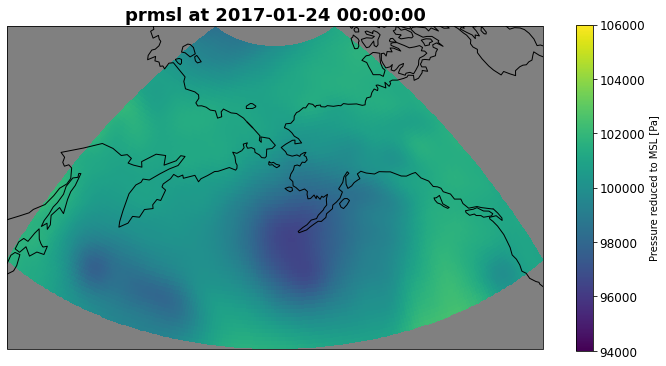

In [10]:
plt.figure(figsize=(12, 6))
viz.pyplot_mesh(
    data,
    "prmsl",
    projection=crs.Orthographic(-170, 45),
    timestep=160,
    vrange=[vmin, vmax],
    features=[("coastlines", {"resolution": "110m", "color": "black"})],
)

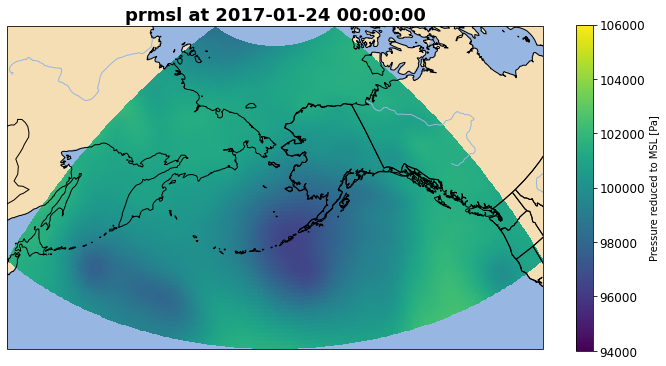

In [12]:
plt.figure(figsize=(12, 6))
viz.pyplot_mesh(
    data,
    "prmsl",
    projection=crs.Orthographic(-170, 45),
    timestep=160,
    vrange=[vmin, vmax]
)

### Create a gif from saved images

In [34]:
gif_images_path = ds_path / "gif_images"
gif_images_path.mkdir(exist_ok=True)
gif_path = ds_path / "test.gif"
gif_images_path, gif_path

(PosixPath('/Users/carlos/repos/pyadcirc/notebooks/data/ncar/Feb2011/gif_images'),
 PosixPath('/Users/carlos/repos/pyadcirc/notebooks/data/ncar/Feb2011/test.gif'))

In [19]:
from typing import AnyStr, Callable, List, Tuple
from pathlib import Path

def gen_image(step: int, path: str):
    viz.pyplot_mesh(
        data,
        "prmsl",
        timestep=step,
        save_path=path,
        projection=crs.PlateCarree(central_longitude=-170),
        vrange=[vmin, vmax],
        features=[("coastlines", {"resolution": "50m", "color": "black"})],
    )

def generate_gif(name:str, gen_image: Callable, steps: List=None, figsize: Tuple=(12,6), build_dir: str=None):

    build_dir = Path.cwd() if build_dir is None else Path(build_dir)

    gif_images_path = build_dir / ".gif_images"
    gif_images_path.mkdir(exist_ok=True)
    gif_path = build_dir / name

    images = []
    if steps is None:
        steps = range(len(data["time"]))
    for t in steps:
        plt.figure(figsize=(12, 6))
        filename = str(gif_images_path / f"{t}.png")
        gen_image(t, filename)
        plt.close()
        images.append(filename)

    with iio.get_writer(str(gif_path), mode="I") as writer:
        for i in images:
            writer.append_data(iio.imread(i))

    optimize(gif_path)

    for i in images:
        Path(i).unlink()



generate_gif('test.gif', gen_image, steps=range(25))

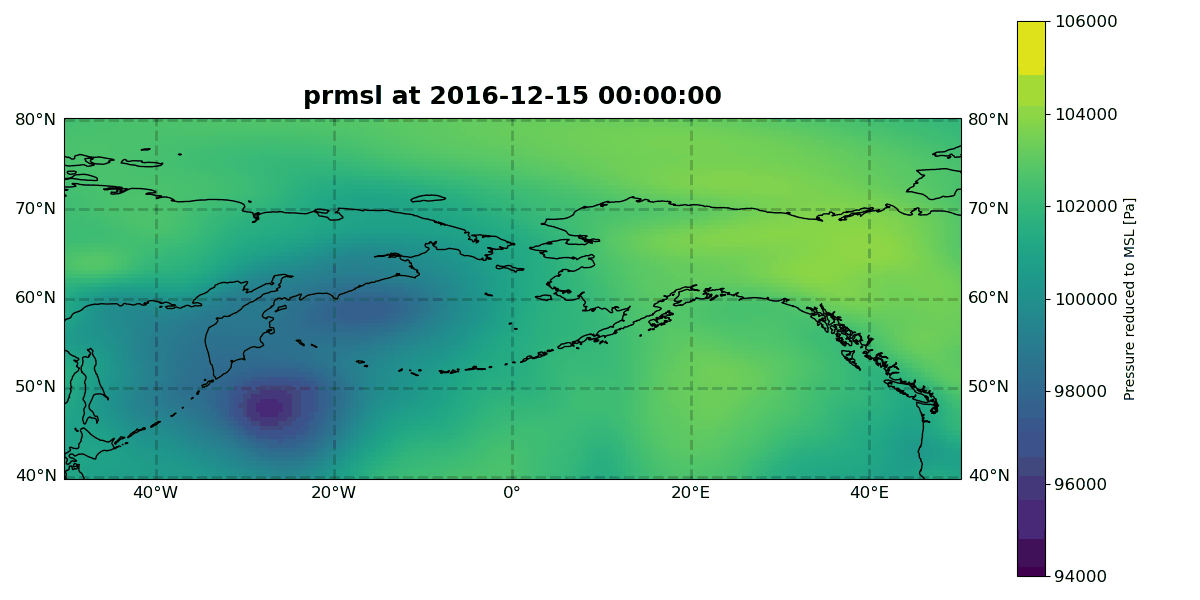

In [23]:
Image(filename=str(ds_path / "optimized.gif"))

# Alaska Storms

Downloading data for the following storms:


In [4]:
bounding_box = [140, 240, 40, 80]
data_types = ["prmsl", "wnd10m", "icecon"]

ak_dt = ncar.NCARDataTransfer(CLIENT_ID)

NameError: name 'CLIENT_ID' is not defined

## Downloading Storm Data

### Feb 2011 Pack Ice

In [64]:
# Make directory for data set
start_date = "2011-02-01"
end_date = "2011-03-05"
data_types = ["prmsl", "wnd10m", "icecon"]

name = "Feb2011-PackIce"
ds_path = data_dir / name
ds_path.mkdir(exist_ok=True)
ds_path

PosixPath('/Users/carlos/repos/pyadcirc/notebooks/data/ncar/Feb2011-PackIce')

See what files are available (gdas or cdas, and .l or not)

In [28]:
res = dt.list_files("ds094.1", [d + '.*' for d in data_types], start_date, end_date, pp=True)

+---------------------------+-----------+
|            name           |    size   |
+---------------------------+-----------+
|   prmsl.gdas.201102.grb2  | 146.9 MiB |
|  prmsl.l.gdas.201102.grb2 |  11.6 MiB |
|  wnd10m.gdas.201102.grb2  | 943.2 MiB |
| wnd10m.l.gdas.201102.grb2 |  27.5 MiB |
|  icecon.gdas.201102.grb2  |  83.4 MiB |
| icecon.l.gdas.201102.grb2 |  3.9 MiB  |
|   prmsl.gdas.201103.grb2  | 163.2 MiB |
|  prmsl.l.gdas.201103.grb2 |  12.9 MiB |
|  wnd10m.gdas.201103.grb2  |  1.0 GiB  |
| wnd10m.l.gdas.201103.grb2 |  30.5 MiB |
|  icecon.gdas.201103.grb2  |  92.8 MiB |
| icecon.l.gdas.201103.grb2 |  4.2 MiB  |
+---------------------------+-----------+


In [44]:
dts = [d + '.gdas' for d in data_types]
dts

['prmsl.gdas', 'wnd10m.gdas', 'icecon.gdas']

In [30]:
tdata = dt.stage(
    "ds094.1", dts, local_endpoint, str(ds_path), start_date, end_date
)

transfer_result = dt.submit(tdata)

print("task_id = ", transfer_result["task_id"])

task_id =  9487d68e-99e7-11ec-b86b-3912f602f346


### Nov 2011 Fringe Ice

In [37]:
# Make directory for data set
start_date = "2011-10-20"
end_date = "2011-11-20"
data_types = ["prmsl", "wnd10m", "icecon"]

name = "Nov2011-FringeIce"
ds_path = data_dir / name
ds_path.mkdir(exist_ok=True)
ds_path

PosixPath('/Users/carlos/repos/pyadcirc/notebooks/data/ncar/Nov2011-FringeIce')

In [32]:
res = dt.list_files("ds094.1", [d + '.*' for d in data_types], start_date, end_date, pp=True)

+----------------------------+------------+
|            name            |    size    |
+----------------------------+------------+
|  prmsl.cdas1.201110.grb2   | 160.0 MiB  |
| prmsl.l.cdas1.201110.grb2  |  12.8 MiB  |
|  wnd10m.cdas1.201110.grb2  |  1.0 GiB   |
| wnd10m.l.cdas1.201110.grb2 |  30.6 MiB  |
|  icecon.cdas1.201110.grb2  |  98.9 MiB  |
| icecon.l.cdas1.201110.grb2 |  4.1 MiB   |
|  prmsl.cdas1.201111.grb2   | 162.5 MiB  |
| prmsl.l.cdas1.201111.grb2  |  12.7 MiB  |
|  wnd10m.cdas1.201111.grb2  | 1020.0 MiB |
| wnd10m.l.cdas1.201111.grb2 |  29.5 MiB  |
|  icecon.cdas1.201111.grb2  | 103.3 MiB  |
| icecon.l.cdas1.201111.grb2 |  4.2 MiB   |
+----------------------------+------------+


In [33]:
dts = [d + '.cdas1' for d in data_types]
dts

['prmsl.cdas1', 'wnd10m.cdas1', 'icecon.cdas1']

In [34]:
tdata = dt.stage(
    "ds094.1", dts, local_endpoint, str(ds_path), start_date, end_date
)

transfer_result = dt.submit(tdata)

print("task_id = ", transfer_result["task_id"])

task_id =  bb096f8e-99e7-11ec-b86b-3912f602f346


### Jan 2017 Partial Ice

In [58]:
# Make directory for data set
start_date = "2016-12-15"
end_date = "2017-02-05"
data_types = ["prmsl", "wnd10m", "icecon"]

name = "Jan2017-PartialIce"
ds_path = data_dir / name
ds_path.mkdir(exist_ok=True)
ds_path

PosixPath('/Users/carlos/repos/pyadcirc/notebooks/data/ncar/Jan2017-PartialIce')

In [36]:
res = dt.list_files("ds094.1", [d + '.*' for d in data_types], start_date, end_date, pp=True)

+----------------------------+-----------+
|            name            |    size   |
+----------------------------+-----------+
|  prmsl.cdas1.201612.grb2   | 109.6 MiB |
| prmsl.l.cdas1.201612.grb2  |  10.3 MiB |
|  wnd10m.cdas1.201612.grb2  |  1.0 GiB  |
| wnd10m.l.cdas1.201612.grb2 |  30.6 MiB |
|  icecon.cdas1.201612.grb2  | 100.6 MiB |
| icecon.l.cdas1.201612.grb2 |  4.3 MiB  |
|  prmsl.cdas1.201701.grb2   | 110.2 MiB |
| prmsl.l.cdas1.201701.grb2  |  10.4 MiB |
|  wnd10m.cdas1.201701.grb2  |  1.0 GiB  |
| wnd10m.l.cdas1.201701.grb2 |  30.5 MiB |
|  icecon.cdas1.201701.grb2  |  91.8 MiB |
| icecon.l.cdas1.201701.grb2 |  4.1 MiB  |
|  prmsl.cdas1.201702.grb2   |  99.4 MiB |
| prmsl.l.cdas1.201702.grb2  |  9.4 MiB  |
|  wnd10m.cdas1.201702.grb2  | 947.3 MiB |
| wnd10m.l.cdas1.201702.grb2 |  27.5 MiB |
|  icecon.cdas1.201702.grb2  |  77.9 MiB |
| icecon.l.cdas1.201702.grb2 |  3.6 MiB  |
+----------------------------+-----------+


In [37]:
dts = [d + '.cdas1' for d in data_types]
dts

['prmsl.cdas1', 'wnd10m.cdas1', 'icecon.cdas1']

In [38]:
tdata = dt.stage(
    "ds094.1", dts, local_endpoint, str(ds_path), start_date, end_date
)

transfer_result = dt.submit(tdata)

print("task_id = ", transfer_result["task_id"])

task_id =  e3abca68-99e7-11ec-b86b-3912f602f346


## Convert to ADCIRC netcdf input

Edit `d` value to appropriate value from `dts` list. Can take a while to do for large files.

Make sure ds_path is pointing to appropriate data-set.

In [34]:
d = 'icecon.cdas1'

In [35]:
files = [f for f in ds_path.iterdir() if d in str(f)]

print(f"Opening data for {d}")
data = xr.open_mfdataset(files)

# Select data for time range, at first step within each time interval
data = data.sel(
    time=slice(start_date, end_date),
    latitude=slice(bounding_box[3], bounding_box[2]),
    longitude=slice(bounding_box[0], bounding_box[1]),
)
data = data.isel(step=0)

# Drop unecessary coordiantes - only need time, latitude, and longitude
drop = [
    x for x in list(data.coords.keys()) if x not in ["time", "latitude", "longitude"]
]
for x in drop:
    data = data.drop(x)

data

Opening data for icecon.cdas1


<xarray.Dataset>
Dimensions:    (time: 212, latitude: 195, longitude: 489)
Coordinates:
  * time       (time) datetime64[ns] 2016-12-15 ... 2017-02-05T18:00:00
  * latitude   (latitude) float64 79.83 79.63 79.42 79.22 ... 40.58 40.37 40.17
  * longitude  (longitude) float64 140.1 140.3 140.5 140.7 ... 239.5 239.7 239.9
Data variables:
    siconc     (time, latitude, longitude) float32 dask.array<chunksize=(68, 195, 489), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2022-03-02T02:13 GRIB to CDM+CF via cfgrib-0.9.1...

In [36]:
#  Write netcdf fort file
if 'prmsl' in d:
    out_file = "fort.221.nc"
# elif 'wnd10m' in d:
#     out_file = "fort.222.nc"
elif 'icecon' in d:
    out_file = "fort.225.nc"

print(f"Writing {out_file}")
data.to_netcdf(str(ds_path / out_file))

# Remove downloaded data
# for f in files:
#     os.system(f"rm {str(f)}*")

Writing fort.225.nc


## Viz

In [45]:
proj_pc = crs.PlateCarree(central_longitude=-170)
proj_ortho = crs.Orthographic(-170, 45)

In [65]:
ds_path

PosixPath('/Users/carlos/repos/pyadcirc/notebooks/data/ncar/Feb2011-PackIce')

In [66]:
data = xr.open_dataset(str(ds_path / "fort.225.nc"))
data

<xarray.Dataset>
Dimensions:    (time: 132, latitude: 195, longitude: 489)
Coordinates:
  * time       (time) datetime64[ns] 2011-02-01 ... 2011-03-05T18:00:00
  * latitude   (latitude) float64 79.83 79.63 79.42 79.22 ... 40.58 40.37 40.17
  * longitude  (longitude) float64 140.1 140.3 140.5 140.7 ... 239.5 239.7 239.9
Data variables:
    siconc     (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2022-03-02T00:38 GRIB to CDM+CF via cfgrib-0.9.1...

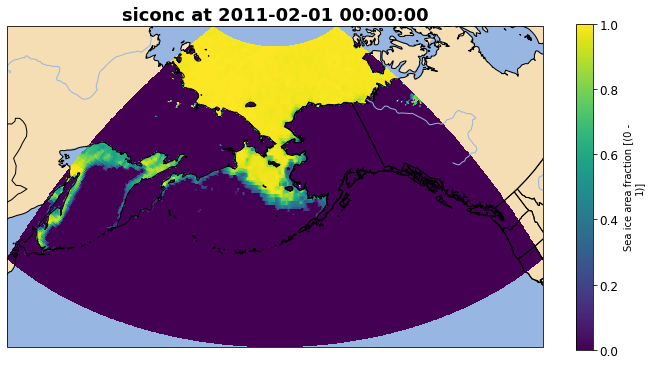

In [67]:
plt.figure(figsize=(12, 6))
viz.pyplot_mesh(
    data,
    "siconc",
    projection=proj_ortho,
    timestep=0)
#     features=[("coastlines", {"resolution": "110m", "color": "black"})],
# )

In [69]:
def gen_image(step: int, path: str):
    viz.pyplot_mesh(
        data,
        "siconc",
        save_path=path,
        projection=proj_ortho,
        timestep=step)

gif_path = viz.generate_gif('test.gif', gen_image, steps=range(132))

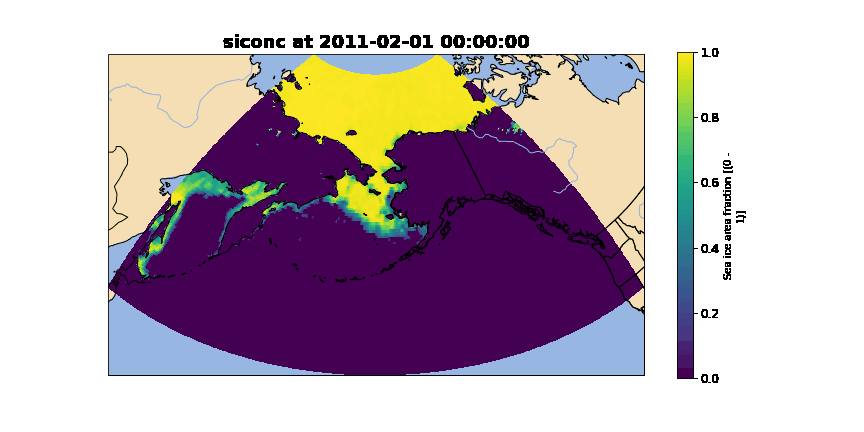

In [70]:
Image(filename=str(gif_path))